In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSSB'
m='TOBS'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|    13|[30 55 30 55 30 5...|1904.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     3|[28 58 28 58 00 5...|1948.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|    10|[A0 56 40 56 40 5...|1949.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     8|[A0 56 40 56 00 5...|1950.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     7|[28 58 F0 56 00 5...|1951.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

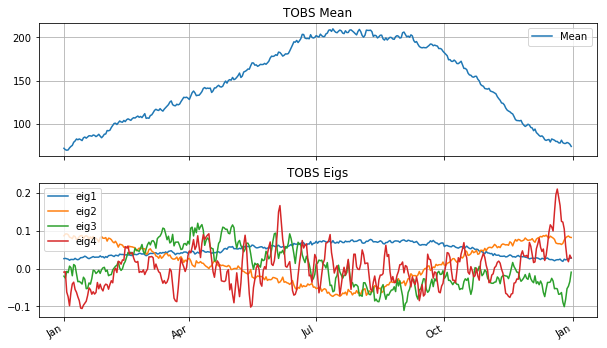

In [14]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [11]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

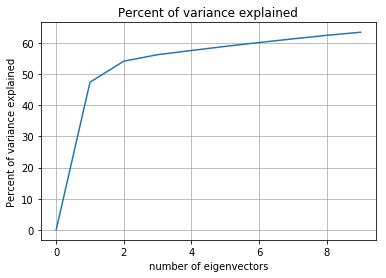

In [12]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [15]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [16]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1186
after filter 1186


In [17]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [22]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=1, figsize=(15,3)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
|  -184.880314854865| 0.1541705739546394|
|-208.92378020076188|0.16211978980754047|
|-116.02632202133475|0.13474338947408324|
| -150.0279727961904|0.17924030607576244|
|-148.39900648740834|0.17792619500092044|
|-128.88245556074364|0.24764863197542272|
|   175.841783779185| 0.1847726650377749|
|-242.29010708799268|0.18410891183182704|
| -136.3122569821453|0.19034427998673245|
| -114.5854858828734|0.19259474776328422|
+-------------------+-------------------+
only showing top 10 rows



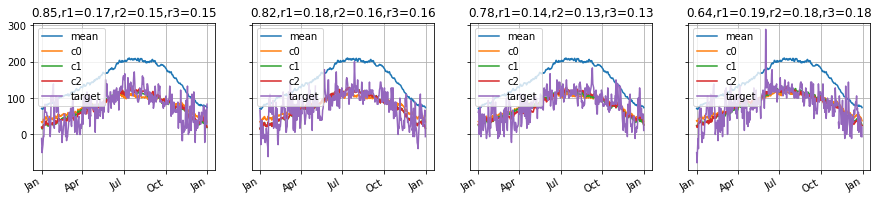

In [24]:
df5=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(10)
plot_recon_grid(rows)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
| -176.1199213131867|0.17119375769785602|
|-2.2339274010295114|0.21010045239100686|
|-173.87588330728215|0.19763141264954587|
|  76.29373153579473|0.23265776747300843|
| -138.4290687094266| 0.2287371588328306|
|-169.70947192696482| 0.2092433651337821|
| -114.6715018518756|0.18052557612755932|
|-221.30086508955827|0.18824087778664503|
|-57.861449655714665|0.22995956508077955|
|-247.45827363629837|0.19751664484643613|
+-------------------+-------------------+
only showing top 10 rows



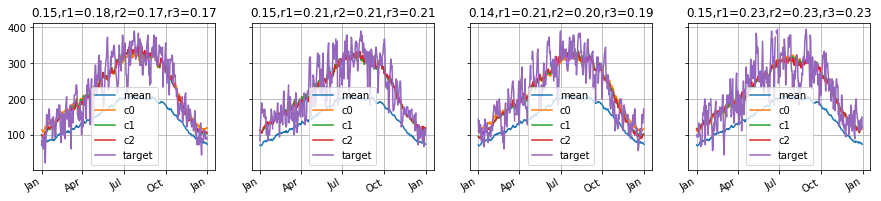

In [26]:
df5=df3.filter(df3.res_1<0.4).sort(df3.coeff_1,ascending=False)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(10)
plot_recon_grid(rows)

In [20]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(4)
#df3.select('coeff_2','res_2').show()
df4.select('coeff_2','res_2').show(10)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
| -549.6313050523225|0.26326372771410966|
| -513.2322420484593| 0.3999472680428191|
| -475.6434210120821|0.38790964632836894|
| -475.5074679144002|0.39949779833614074|
|-466.77290361897224| 0.3346984170757565|
| -466.0710802288236|0.32862538953632725|
| -450.5616463180381| 0.3971336324539383|
| -450.1245406526991| 0.3705252188254667|
|-442.10087170038605|0.21829738379071684|
|-441.66193912209667|0.22503777161752014|
+-------------------+-------------------+
only showing top 10 rows



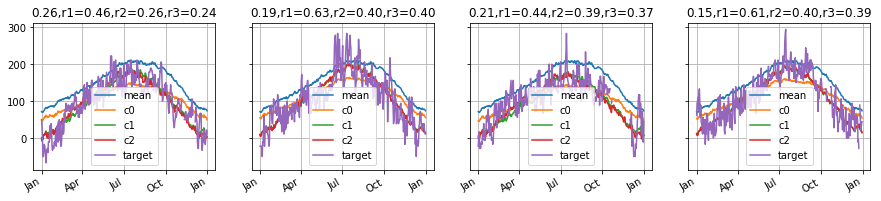

In [23]:
plot_recon_grid(rows)

+-----------------+-------------------+
|          coeff_2|              res_2|
+-----------------+-------------------+
|589.3252804887148| 0.3755992194238123|
|564.5300962958037|0.36964136068871584|
|561.0962743275243|0.34011703254204867|
|550.5773382528387|0.32833896376329264|
|550.4818515926057|0.25147947744212845|
|547.3843616102278|0.30002718791689076|
|532.1792606537126| 0.2699271133692147|
|531.3900629946147|0.30116989232251795|
|529.6812041801081|0.25494457867212356|
|527.8067656995802| 0.3074620519181211|
+-----------------+-------------------+
only showing top 10 rows



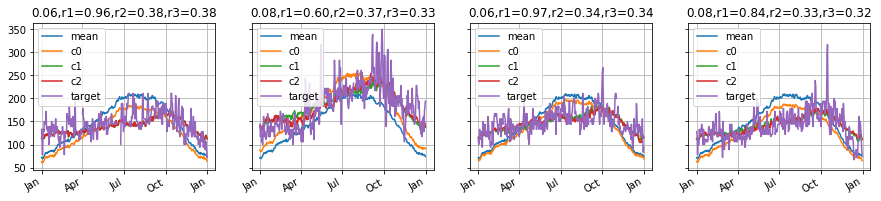

In [27]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df4.take(4)
#df3.select('coeff_2','res_2').show()
df4.select('coeff_2','res_2').show(10)
plot_recon_grid(rows)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
|-196.43431094948113| 0.3830765804712787|
|-374.21991762577835|0.40624519103105017|
|-147.76929900795383|  0.312489061549716|
|-123.35388038616291| 0.3047224175544009|
|   -469.40029131293|0.46631665525083665|
|-128.88245556074364|0.24764863197542272|
| -92.43027483146322| 0.3195775863807084|
|-135.11552291001675| 0.3613061894457202|
|  177.5408184145699| 0.3168796935009157|
|  330.0195087668802| 0.4037456736092541|
+-------------------+-------------------+
only showing top 10 rows



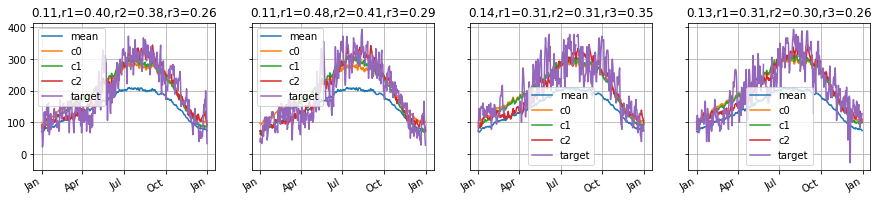

In [25]:
df5=df3.filter(df3.res_3<0.4).sort(df3.coeff_3)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(10)
plot_recon_grid(rows)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
|  145.2091325956124|0.24995360020047835|
|-233.27883462735787|0.27971586526837366|
|-211.64994676966188|0.22460579693216898|
|-319.86100349409264| 0.2836125744630265|
| -71.41635374590938| 0.3149492601288239|
| 136.89932472339012|0.32421107525245796|
|-247.45827363629837|0.19751664484643613|
|-189.94717038729618| 0.4268783127931715|
|-169.70947192696482| 0.2092433651337821|
| -450.1245406526991| 0.3705252188254667|
+-------------------+-------------------+
only showing top 10 rows



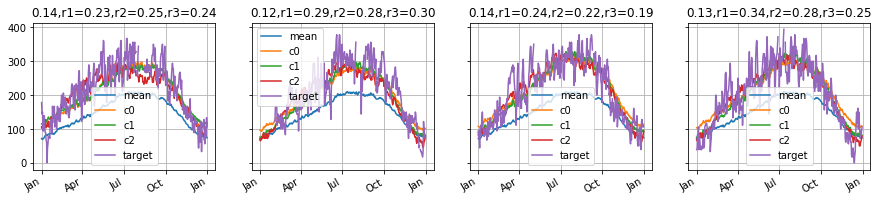

In [29]:
df5=df3.filter(df3.res_3<0.4).sort(df3.coeff_3,ascending=False)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(10)
plot_recon_grid(rows)

In [17]:
df3.sort?

In [18]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(4)

+-----------------+-------------------+
|          coeff_2|              res_2|
+-----------------+-------------------+
|60.63852305285171| 0.2912801488907902|
|52.47089811168702|0.14294129639215325|
|52.08819494044404|0.29308371014585616|
|22.37176971613426| 0.1922884014949346|
+-----------------+-------------------+
only showing top 4 rows



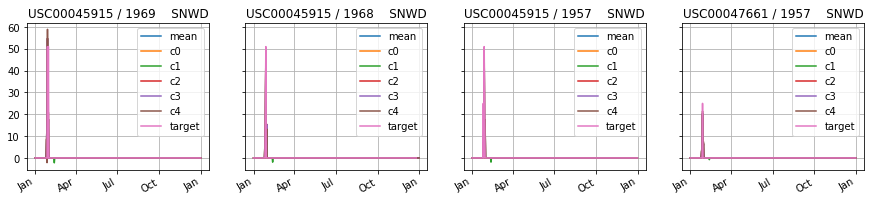

In [20]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.136773288645
residual normalized norm  after mean + top eigs: [ 0.23425724  0.2499536   0.24011651]


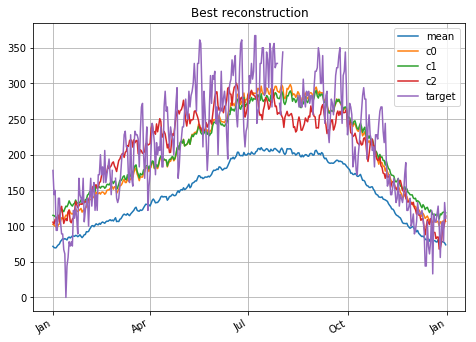

In [30]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [31]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    P=np.append(P,1)
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

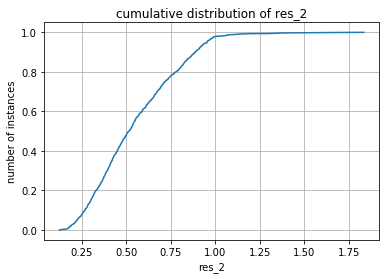

In [32]:
plot_CDF('res_2')

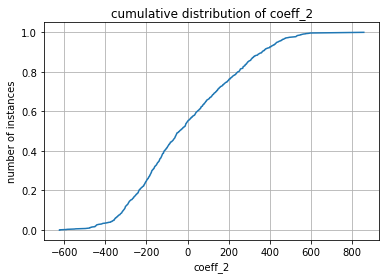

In [33]:
plot_CDF('coeff_2')

In [34]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [35]:
!du -sh $data_dir/*.parquet

4.7M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.1M	../../Data/Weather/US_Weather_SSSBSSSB.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.2M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.2M	../../Data/Weather/decon_SSSBSSSB_PRCP.parquet
36K	../../Data/Weather/decon_SSSBSSSB_SNWD.parquet
3.2M	../../Data/Weather/decon_SSSBSSSB_TOBS.parquet
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 38788)
----------------------------------------


Traceback (most recent call last):
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 652, in __init__
    self.handle()
  File "/spark-2.1.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/spark-2.1.0-bin-hadoop2.7/python/pyspark/serializers.py", line 557, in read_int
    raise EOFError
EOFError
